In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import os
import glob
import shutil

from keras.datasets import mnist
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from tensorflow.keras.preprocessing.image import ImageDataGenerator 

Using TensorFlow backend.


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cp drive/'My Drive'/datasets/intel-image-classification.zip /content/intel_image.zip

In [0]:
!unzip intel_image.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jpg  
  inflating: seg_train/seg_train/mountain/7695.jp

In [0]:
data_dir = '/content/seg_train/seg_train'

In [0]:
classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [0]:
for c1 in classes:
    img_path = os.path.join(data_dir, c1)
    images = glob.glob(img_path + '/*.jpg')
    print("{}: {} Images".format(c1, len(images)))
    train, val = images[:round(len(images)*0.8)], images[round(len(images)*0.8):]

    for t in train:
        if not os.path.exists(os.path.join(data_dir, 'train', c1)):
            os.makedirs(os.path.join(data_dir, 'train', c1))
        shutil.move(t, os.path.join(data_dir, 'train', c1))

    for v in val:
        if not os.path.exists(os.path.join(data_dir, 'val', c1)):
            os.makedirs(os.path.join(data_dir, 'val', c1))
        shutil.move(v, os.path.join(data_dir, 'val', c1))

buildings: 2191 Images
forest: 2271 Images
glacier: 2404 Images
mountain: 2512 Images
sea: 2274 Images
street: 2382 Images


In [0]:
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')

In [0]:
batch_size = 100
img_shape = 150

In [0]:
def plot_image(image_arr):
    fig, axes = plt.subplots(1, 5, figsize = (20, 20))
    axes = axes.flatten()
    for img, ax in zip(image_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

Found 11228 images belonging to 6 classes.


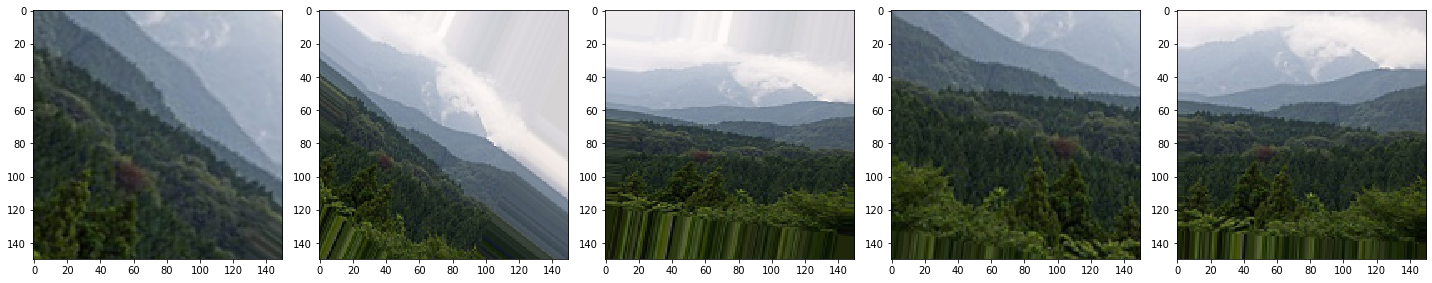

(150, 150, 3)
(150, 150, 3)
(150, 150, 3)
(150, 150, 3)
(150, 150, 3)


In [0]:
img_train_gen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = (45),
    zoom_range = 0.5,
    horizontal_flip = True,
    width_shift_range = 0.15,
    height_shift_range = 0.15
)

train_data_generator = img_train_gen.flow_from_directory(batch_size = batch_size,
                                             directory = train_dir,
                                             shuffle = True,
                                             target_size = (img_shape, img_shape))

augumnted_image = [train_data_generator[0][0][0] for i in range(5)]
plot_image(augumnted_image)
for img_sh in augumnted_image:
    print(img_sh.shape)

Found 2806 images belonging to 6 classes.


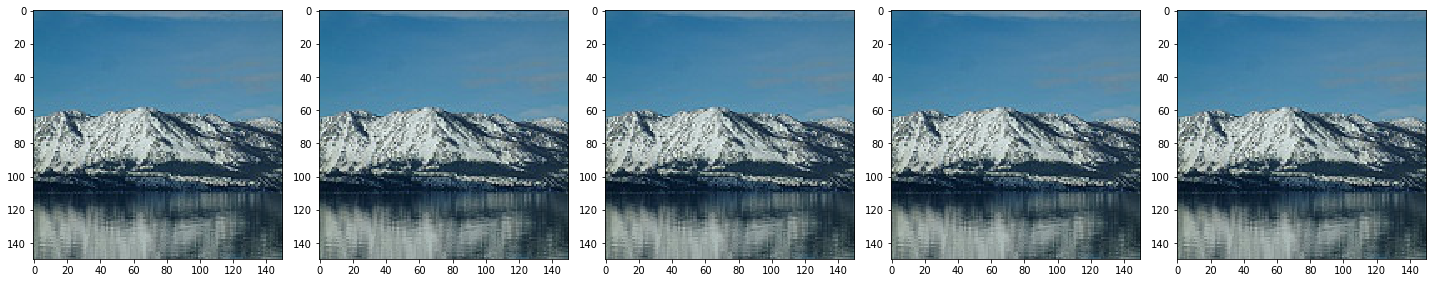

In [0]:
img_valid_gen = ImageDataGenerator(rescale=1./255)

valid_data_generator = img_valid_gen.flow_from_directory(batch_size = batch_size,
                                             directory = val_dir,
                                             shuffle = True,
                                             target_size = (img_shape, img_shape))

augumnted_image = [valid_data_generator[0][0][0] for i in range(5)]
plot_image(augumnted_image)

In [0]:
sample_training_images, _ = next(train_data_generator)

In [0]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32, 3, activation='relu', padding = 'same', input_shape= (150, 150, 3)),
                                    #tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, 3, activation='relu', padding = 'same'),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(128, 3, activation='relu', padding = 'same'),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(128, 3, activation='relu', padding = 'same'),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(512, activation='relu'),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(6, activation = 'softmax')
                                ])

In [0]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch : 1e-7 * 10 ** (epoch/10))
optimizer = keras.optimizers.Adam(learning_rate = 1e-7)

for c1 in classes:
    img_path = os.path.join(data_dir, c1)
    images = glob.glob(img_path + '/*.jpg')

model.compile(optimizer=optimizer, loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

epochs = 100

history = model.fit_generator(
    train_data_generator,
    steps_per_epoch = int(np.ceil(11228/float(batch_size))),
    epochs = epochs, 
    verbose = 1,
    #validation_data = valid_data_generator,
    #validation_steps = int(np.ceil(2086/float(batch_size))))
    callbacks = [lr_scheduler]
)

  ...
    to  
  ['...']
Train for 113 steps
Epoch 1/100
113/113 [==============================] - 85s 751ms/step - loss: 1.7938 - accuracy: 0.1791
Epoch 2/100
113/113 [==============================] - 85s 753ms/step - loss: 1.7898 - accuracy: 0.1911
Epoch 3/100
113/113 [==============================] - 84s 744ms/step - loss: 1.7851 - accuracy: 0.2000
Epoch 4/100
113/113 [==============================] - 84s 740ms/step - loss: 1.7810 - accuracy: 0.2245
Epoch 5/100
113/113 [==============================] - 85s 748ms/step - loss: 1.7746 - accuracy: 0.2455
Epoch 6/100
113/113 [==============================] - 85s 748ms/step - loss: 1.7671 - accuracy: 0.2814
Epoch 7/100
113/113 [==============================] - 85s 748ms/step - loss: 1.7562 - accuracy: 0.3177
Epoch 8/100
113/113 [==============================] - 85s 755ms/step - loss: 1.7386 - accuracy: 0.3595
Epoch 9/100
113/113 [==============================] - 85s 751ms/step - loss: 1.7121 - accuracy: 0.4006
Epoch 10/100
113/11

[1e-07, 1, 0, 1]

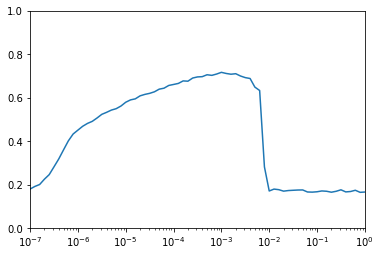

In [0]:
plt.semilogx(history.history['lr'], history.history['accuracy'])
plt.axis([1e-7, 1, 0, 1])

In [0]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32, 3, activation='relu', padding = 'same', input_shape= (150, 150, 3)),
                                    #tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(64, 3, activation='relu', padding = 'same'),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(128, 3, activation='relu', padding = 'same'),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Conv2D(128, 3, activation='relu', padding = 'same'),
                                    tf.keras.layers.MaxPooling2D(2, 2),

                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(512, activation='relu'),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(6, activation = 'softmax')
                                ])


#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch : 1e-7 * 10 * (epoch/10))
optimizer = keras.optimizers.Adam(learning_rate = 1e-3)
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 20)
checkpointer = tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)

for c1 in classes:
    img_path = os.path.join(data_dir, c1)
    images = glob.glob(img_path + '/*.jpg')

model.compile(optimizer=optimizer, loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

epochs = 100

history = model.fit_generator(
    train_data_generator,
    steps_per_epoch = int(np.ceil(11228/float(batch_size))),
    epochs = epochs, 
    verbose = 1,
    callbacks = [early_stopping, checkpointer],
    validation_data = valid_data_generator,
    validation_steps = int(np.ceil(2086/float(batch_size)))
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 113 steps, validate for 21 steps
Epoch 1/100
113/113 [==============================] - 90s 798ms/step - loss: 1.2904 - accuracy: 0.4822 - val_loss: 1.0091 - val_accuracy: 0.6086
Epoch 2/100
113/113 [==============================] - 88s 782ms/step - loss: 1.0421 - accuracy: 0.6007 - val_loss: 0.8826 - val_accuracy: 0.6610
Epoch 3/100
113/113 [==============================] - 89s 790ms/step - loss: 0.9714 - accuracy: 0.6367 - val_loss: 0.8232 - val_accuracy: 0.6971
Epoch 4/100
113/113 [==============================] - 89s 790ms/step - loss: 0.9210 - accuracy: 0.6499 - val_loss: 0.7254 - val_accuracy: 0.7305
Epoch 5/100
113/113 [==============================] - 90s 794ms/step - loss: 0.8498 - accuracy: 0.6836 - val_loss: 0.7220 - val_accuracy: 0.7248
Epoch 6/100
113/113 [==============================] - 90s 792ms/step - loss: 0.8334 - accuracy: 0.6936 - val_loss: 0.7253 - val_accuracy: 0.7348
Epoch 7/100
113/113 [==========

In [0]:
best_model = tf.keras.models.load_model('best_model.h5')

In [0]:
print(best_model)